# Example 2: tunable part with large area and tiny $\varepsilon_r$ range

In this example, we consider the whole design region under modulation where the dielectric constant can be varied only a little. The goal is to design a compact 1-to-3 optical switch.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/research/meta-learnt-optical-switch

Mounted at /content/gdrive
/content/gdrive/MyDrive/research/meta-learnt-optical-switch


In [2]:
!pip install git+https://github.com/fancompute/ceviche.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/fancompute/ceviche.git to /tmp/pip-req-build-vjf6983d
  Running command git clone --filter=blob:none --quiet https://github.com/fancompute/ceviche.git /tmp/pip-req-build-vjf6983d
  Resolved https://github.com/fancompute/ceviche.git to commit dcb8587c46e8e64b281004c3dee02a8ecd139721
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for ceviche: filename=ceviche-0.1.3-py3-none-any.whl size=32597 sha256=c1aebfb70dce4fad4085f1477f66834ada126641caa541928783bde2984f55be
  Stored in directory: /tmp/pip-ephem-wheel-cache-ga99ocff/wheels/a5/b4/1f/0c75dd0e0440bc090abe88f3cf5075526cb16c7e30236c728c
  Created wheel for pyMKL: filename=pyMKL-0.0.3-py3-none-any.whl size=6748 sha256=bf1b061ce7378a254ea45c9906bf987394081de9270d0f287ed1375ff47fe96d
  Stored in directory: /root/.cache/pip/wheels/33/cb/ef/d42f20635ef9ffcf573867587d

In [3]:
import sys, os
sys.path.append('/Users/beicheng/Downloads/ceviche-master-original')

import numpy as np
import autograd.numpy as npa
import pickle

import copy

import matplotlib as mpl
mpl.rcParams['figure.dpi']=100

import matplotlib.pylab as plt

from autograd.scipy.signal import convolve as conv
from skimage.draw import disk
from tqdm import tqdm

import ceviche
from ceviche import fdfd_ez, jacobian
from ceviche.optimizers import adam_optimize
from ceviche.modes import insert_mode

import collections
# Create a container for our slice coords to be used for sources and probes
Slice = collections.namedtuple('Slice', 'x y')

In [4]:
# Projection that drives rho towards a "binarized" design with values either 0 or 1 
def operator_proj(rho, eta=0.5, beta=100, N=1):
    """Density projection
    eta     : Center of the projection between 0 and 1
    beta    : Strength of the projection
    N       : Number of times to apply the projection
    """
    for i in range(N):
        rho =  npa.divide(npa.tanh(beta * eta) + npa.tanh(beta * (rho - eta)), 
                          npa.tanh(beta * eta) + npa.tanh(beta * (1 - eta)))
    
    return rho

# Blurring filter that results in smooth features of the structure
# First we define a function to create the kernel
def _create_blur_kernel(radius):
    """Helper function used below for creating the conv kernel"""
#     rr, cc = circle(radius, radius, radius+1)
    rr, cc = disk((radius, radius), radius+1)
    kernel = np.zeros((2*radius+1, 2*radius+1), dtype=np.float)
    kernel[rr, cc] = 1
    return  kernel/kernel.sum()

# Then we define the function to apply the operation
def operator_blur(rho, radius=2, N=1):
    """Blur operator implemented via two-dimensional convolution
    radius    : Radius of the circle for the conv kernel filter
    N         : Number of times to apply the filter
    
    Note that depending on the radius, the kernel is not always a
    perfect circle due to "pixelation" / stair casing
    """
    
    kernel = _create_blur_kernel(radius)
    
    for i in range(N):
        # For whatever reason HIPS autograd doesn't support 'same' mode, so we need to manually crop the output
        rho = conv(rho, kernel, mode='full')[radius:-radius,radius:-radius]
    
    return rho

In [5]:
directory = 'ex2/'
if not os.path.exists(directory):
    os.makedirs(directory)

EPS_MIN_ROD = 0.9
EPS_MAX_ROD = 1.1

In [6]:
# Angular frequency of the source in 1/s
omega=2*np.pi*200e12
# Spatial resolution in meters
dl=40e-9
# Number of pixels in x-direction
Nx=120
# Number of pixels in y-direction
Ny=120
# Number of pixels in the PMLs in each direction
Npml=20
# Minimum value of the relative permittivity
epsr_min=1.0
# Maximum value of the relative permittivity
epsr_max=12.0
# Radius of the smoothening features
blur_radius=5
# Number of times to apply the blur
N_blur=1
# Strength of the binarizing projection
# beta=500.0
beta=5.0
# Middle point of the binarizing projection
eta=0.5
# Number of times to apply the blur
N_proj=1
# Space between the PMLs and the design region (in pixels)
space=10
# Width of the waveguide (in pixels)
wg_width=11
# Length in pixels of the source/probe slices on each side of the center point
space_slice=2

# Number of epochs in the optimization 
Nsteps=50
# Step size for the Adam optimizer
step_size=2e-4

In [7]:
### locations of the 3 output waveguides, in units of pixels
output_offs = [-18,0,18]
def init_domain(Nx, Ny, Npml, space=10, wg_width=10, space_slice=5, offset=0):
    """Initializes the domain and design region

    space       : The space between the PML and the structure
    wg_width    : The feed and probe waveguide width
    space_slice : The added space for the probe and source slices
    """
    rho = np.zeros((Nx, Ny))  
    bg_rho = np.zeros((Nx, Ny))  
    design_region = np.zeros((Nx, Ny))
    
    # Input waveguide
    bg_rho[0:int(Npml+space),Ny//2-wg_width//2:Ny//2+wg_width//2+0] = 1

    # Input probe slice
    input_slice = Slice(x=np.array(Npml+0), 
        y=np.arange(Ny//2-wg_width//2-space_slice, Ny//2+wg_width//2+space_slice+0))
    
    # Output waveguide 
    for off in output_offs: ### now putting all 3 waveguides there
        bg_rho[int(Nx-Npml-space)::,Ny//2-wg_width//2-off:Ny//2+wg_width//2+0-off] = 1
    
    # Output probe slice
    output_slice = Slice(x=np.array(Nx-Npml-1), 
                        y=np.arange(Ny//2-wg_width//2-space_slice-offset, Ny//2+wg_width//2+space_slice+0-offset))
    
    design_region[Npml+space:Nx-Npml-space, Npml+space:Ny-Npml-space] = 1
    
    # Const init
    rho[Npml+space:Nx-Npml-space, Npml+space:Ny-Npml-space] = 0.5
    # Random init
    # rho = design_region * np.random.rand(Nx, Ny)

    return rho, bg_rho, design_region, input_slice, output_slice


def viz_sim(epsr, source, slices=[], wantabs = False, ax_to_use=None):
    """Solve and visualize a simulation with permittivity 'epsr'
    """
    simulation = fdfd_ez(omega, dl, epsr, [Npml, Npml])
    Hx, Hy, Ez = simulation.solve(source)
    
    if ax_to_use is None:
        fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(6,3))
    else:
        assert len(ax_to_use)>=2, "viz_sim needs at least two axes for plotting"
        ax = ax_to_use
    if wantabs:
        ceviche.viz.abs(Ez, outline=epsr, ax=ax[0], cbar=False)
    else:
        ceviche.viz.real(Ez, outline=epsr, ax=ax[0], cbar=False)
    for sl in slices:
        ax[0].plot(sl.x*np.ones(len(sl.y)), sl.y, 'b-')
    ceviche.viz.abs(epsr, ax=ax[1], cmap='Greys');
    
    return (simulation, ax)

def viz_abs(val, outline=None, ax=None, cbar=False, cmap='magma', outline_alpha=0.5, outline_val=None): ### copied from ceviche and customized for paper
    if ax is None:
        fig, ax = plt.subplots(1, 1, constrained_layout=True)      
    vmax = np.abs(val).max()
    h = ax.imshow(np.abs(val.T), cmap=cmap, origin='lower', vmin=0, vmax=vmax)  
    if outline_val is None and outline is not None: outline_val = 0.5*(outline.min()+outline.max())
    if outline is not None:
        ax.contour(outline.T, [outline_val], colors='yellow', alpha=outline_alpha)
    ax.set_ylabel('y (µm)')
    ax.set_xlabel(r'x (µm)')
    ax.set_xticks([0,40,80,119])
    ax.set_yticks([0,40,80,119])
    ax.set_xticklabels([0,1.6,3.2,4.8])
    ax.set_yticklabels([0,1.6,3.2,4.8])
    if cbar:
        plt.colorbar(h, ax=ax)
    return 

def viz_sim_for_paper(epsr, source, slices=[], wantabs = False, ax_to_use=None, different_outline = None):
    """Solve and visualize a simulation with permittivity 'epsr'
    """
    simulation = fdfd_ez(omega, dl, epsr, [Npml, Npml])
    Hx, Hy, Ez = simulation.solve(source)
    if different_outline is None:
        different_outline = epsr
    
    if ax_to_use is None:
        fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(6,3))
    else:
        assert len(ax_to_use)>=2, "viz_sim needs at least two axes for plotting"
        ax = ax_to_use
    if wantabs:
        viz_abs(Ez, outline=different_outline, ax=ax[0], cbar=False)
    else:
        print("Go copy viz.real here too")
    for sl in slices:
        ax[0].plot(sl.x*np.ones(len(sl.y)), sl.y, 'b-')
    viz_abs(epsr, outline=different_outline, ax=ax[1], cmap='Greys');
    
    return (simulation, ax)

def mask_combine_rho(rho, bg_rho, design_region):
    """Utility function for combining the design region rho and the background rho
    """
    return rho*design_region + bg_rho*(design_region==0).astype(np.float)

def mode_overlap(E1, E2):
    """Defines an overlap integral between the sim field and desired field
    """
    return npa.abs(npa.sum(npa.conj(E1)*E2))
def field_mag_int(E, mask):
    """
    Computes the integral of |E|^2 over a given mask

    Args:
        E: matrix containing field values
        mask: matrix where all entries are zero except the entries over which
        you would like to integrate
    """
    return npa.abs(npa.sum(npa.multiply(npa.multiply(npa.conj(E), E), mask)))*1e6

In [8]:
def cylinders(coor_list,r_list,eps_list,domain_x=10,domain_y=10,Nx=100,Ny=100,edge_sharpness = 5e0):
    xs = npa.linspace(-domain_x,domain_x,Nx)
    ys = npa.linspace(-domain_y,domain_y,Ny)
    ys, xs = npa.meshgrid(ys,xs)
    dist = npa.zeros([Nx,Ny])
    mask = np.zeros([Nx, Ny])
    for i, coor in enumerate(coor_list):
        x = coor[0]
        y = coor[1]
        r = r_list[i]
        eps = eps_list[i]
        dist += (1-npa.tanh(((xs-x)**2 + (ys-y)**2 - r**2)*edge_sharpness))/2*eps
        mask += (1-npa.tanh(((xs-x)**2 + (ys-y)**2 - r**2)*edge_sharpness))/2
    return dist,mask

def epsr_parameterization(rho, bg_rho, design_region, radius=2, N_blur=1, beta=100, eta=0.5, N_proj=1, rods=None):
    """Defines the parameterization steps for constructing rho
    """
    # Combine rho and bg_rho; Note: this is so the subsequent blur sees the waveguides
    rho = mask_combine_rho(rho, bg_rho, design_region)
    
    # rho = operator_blur(rho, radius=radius, N=N_blur)
    rho = operator_proj(rho, beta=beta, eta=eta, N=N_proj)
    
    # Final masking undoes the blurring of the waveguides
    rho = mask_combine_rho(rho, bg_rho, design_region)

    ### for cylinders
    rods = rods.reshape([Nx,Ny])
    rods = operator_proj(rods, beta=beta, eta=eta, N=N_proj)
    rho = mask_combine_rho(rho*(EPS_MIN_ROD + (EPS_MAX_ROD-EPS_MIN_ROD) * rods), bg_rho, design_region)
    return (epsr_min + (epsr_max-epsr_min) * rho)

In [9]:
def sample_task(task_offset):
    global offset
    offset = task_offset
    global rho, bg_rho, design_region, input_slice, output_slice
    rho, bg_rho, design_region, input_slice, output_slice = \
        init_domain(Nx, Ny, Npml, space=space, wg_width=wg_width, space_slice=space_slice, offset=offset)
    global epsr_init, source, mask_source, probe, mask_probe, mask_probe_unwanted, simulation, Ez, E0
    epsr_init = epsr_parameterization(rho, bg_rho, design_region, \
                                  radius=blur_radius, N_blur=N_blur, beta=beta, eta=eta, N_proj=N_proj, rods=rods)
    source = insert_mode(omega, dl, input_slice.x, input_slice.y, epsr_init, m=1)
    mask_source = np.zeros_like(source,dtype=np.float)
    mask_source[source!=0]=1
    probe = insert_mode(omega, dl, output_slice.x, output_slice.y, epsr_init, m=1) ### differ in location
    mask_probe = np.zeros_like(probe,dtype=np.float)
    mask_probe[probe!=0]=1
    mask_probe_unwanted = 1-mask_probe
    mask_probe_unwanted[:output_slice.x,:] = 0
    mask_probe_unwanted[output_slice.x+1:,:] = 0
    source = np.abs(source)
    source /= source.max()
    probe = np.abs(probe)
    probe /= probe.max()

In [10]:
offset = 0
rho, bg_rho, design_region, input_slice, output_slice = \
    init_domain(Nx, Ny, Npml, space=space, wg_width=wg_width, space_slice=space_slice, offset=offset)

<ipython-input-7-d26a2201a1c0>:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return rho*design_region + bg_rho*(design_region==0).astype(np.float)
<ipython-input-11-43a20be1a6f0>:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_source = np.zeros_like(source,dtype=np.float)
<ipython-input-11-43a20be1a6f0>:13: DeprecationWarning: 

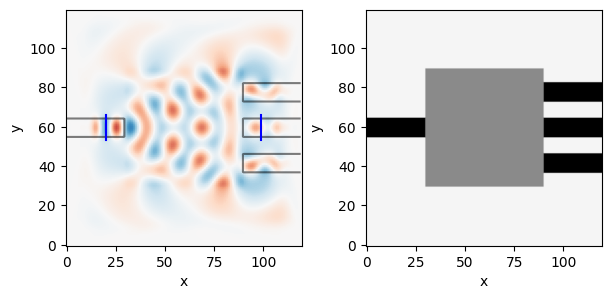

In [11]:
rho_next = rho.flatten()
rods = np.ones_like(rho)*0.5
epsr_init = epsr_parameterization(rho, bg_rho, design_region, \
                                  radius=blur_radius, N_blur=N_blur, beta=beta, eta=eta, N_proj=N_proj, rods = rods)
source = insert_mode(omega, dl, input_slice.x, input_slice.y, epsr_init, m=1)
source = np.abs(source)
source /= source.max()
mask_source = np.zeros_like(source,dtype=np.float)
mask_source[source!=0]=1
probe = insert_mode(omega, dl, output_slice.x, output_slice.y, epsr_init, m=1) ### differ in location
probe = np.abs(probe)
probe /= probe.max()
mask_probe = np.zeros_like(probe,dtype=np.float)
mask_probe[probe!=0]=1
### get normalization factor (field overlap before optimizing)
simulation, ax = viz_sim(epsr_init, source, slices=[input_slice, output_slice])
_, _, Ez = simulation.solve(source)
E0 = mode_overlap(Ez,probe)
E00 = field_mag_int(Ez, mask_probe)

In [12]:
wvgmask = (epsr_init>10).astype(int) ### for contour plot later

In [13]:
def regularize_rho(rho, REG_SYMM = 1e5): ### shape (Nx, Ny), to maximize
    reg = 0
    ### for symmetry heuristic
    # reg -= npa.sum(npa.square(rho-rho[:,::-1])) / len(rho.flatten()) * REG_SYMM
    ### pushing rho away from eta
    reg -= npa.sum(npa.exp(-npa.square(rho.flatten()-eta)/0.01)) / len(rho.flatten()) * REG_BINARIZATION  ### will be changed globally
    return reg

def objective(rho):
    rho = rho.reshape((Nx, Ny))
    epsr = epsr_parameterization(rho, bg_rho, design_region, \
                             radius=blur_radius, N_blur=N_blur, beta=beta, eta=eta, N_proj=N_proj, rods=rods_dict[offset])
    simulation.eps_r = epsr
    _, _, Ez = simulation.solve(source)
    ### feel free to try mode_overlap and field_mag_int in different combinations
    return mode_overlap(Ez, probe) / E0 - field_mag_int(Ez, mask_probe_unwanted) / E00  +\
            regularize_rho(rho)
objective_jac = jacobian(objective, mode='reverse')

def objective_all(rho): ### pooling all tasks
    res = 0
    ### simple sum
    # for offset in task_offsets:
    #     sample_task(offset)
    #     res += objective(rho)
    # return res / len(task_offsets)
    ### softmin
    for offset in task_offsets:
        sample_task(offset)
        res += npa.exp(-objective(rho))
    return -npa.log(res) / len(task_offsets)
objective_all_jac = jacobian(objective_all, mode='reverse')

def regularize_rod(rods, slope=10, left=EPS_MIN_ROD, right=EPS_MAX_ROD): ### objective to maximize
    return npa.sum(- npa.exp((left-rods)*slope) - npa.exp((rods-right)*slope))

def objective_rod(rods):
    epsr = epsr_parameterization(rho_next.reshape((Nx, Ny)), bg_rho, design_region, \
                             radius=blur_radius, N_blur=N_blur, beta=beta, eta=eta, N_proj=N_proj, rods=rods.flatten())
    simulation.eps_r = epsr
    _, _, Ez = simulation.solve(source)
    return mode_overlap(Ez, probe) / E0 - field_mag_int(Ez, mask_probe_unwanted) / E00 ### now we no longer regularize, since it will be projected
objective_jac_rod = jacobian(objective_rod, mode='reverse')


In [14]:
task_offsets = output_offs
losses = {}
losses_short = {} ### 1 pt for each epoch
losses_rods = {}
rods_dict = {}
for task_offset in task_offsets:
    losses[task_offset] = []
    losses_short[task_offset] = []
    losses_rods[task_offset] = []
    rods_dict[task_offset] = np.ones([Nx,Ny]).flatten()*0.5
task_ids = []
REG_BINARIZATION=0
Nsteps_inner = 2
Nsteps_outer = 2

In [15]:
def train_a_while(reptile_stepsize, nepochs):
    global rho_next
    for i_outer in tqdm(range(nepochs)):
        for task_offset in task_offsets:
            sample_task(task_offset)
            # Maximize the objective function using an ADAM optimizer
            (rods_new, loss_rods) = adam_optimize(objective_rod, rods_dict[task_offset], objective_jac_rod,
                                Nsteps=Nsteps_inner, direction='max', step_size=step_size*200,verbose=False) ### give it a boost, as informed by losss curve
            rods_dict[task_offset] = rods_new.flatten()
            losses_rods[task_offset]+=loss_rods
            losses_short[task_offset].append(loss_rods[-1])

        (rho_new, loss) = adam_optimize(objective_all, rho_next, objective_all_jac,
                             Nsteps=Nsteps_outer, direction='max', step_size=step_size,verbose=False)
        rho_next += (rho_new.flatten()-rho_next)*reptile_stepsize
        losses[0]+=loss
def check_structure(rho, beta_scaling = 1, fname = None, offsets = [0]): ## set beta_scaling to 100 to fully binarize
    rho = rho.reshape((Nx, Ny))
    for io, offset in enumerate(offsets):
        sample_task(offset)
        epsr = epsr_parameterization(rho, bg_rho, design_region, \
                                radius=blur_radius, N_blur=N_blur, beta=beta*beta_scaling, eta=eta, N_proj=N_proj, rods=rods_dict[offset])
        if fname is not None:
            fig, ax = plt.subplots(1,2,figsize=[7,3])
            viz_sim(epsr, source, slices=[input_slice, output_slice],wantabs=True, ax_to_use = ax);
            fig.savefig(directory+f'{fname}_{io}.png')
        else:
            viz_sim(epsr, source, slices=[input_slice, output_slice],wantabs=True);
        if fname is not None:
            plt.close('all')
def check_structure_for_paper(rho, beta_scaling = 1, fname = None, offsets = [0]): ## modified version for paper plot
    rho = rho.reshape((Nx, Ny))
    for io, offset in enumerate(offsets):
        sample_task(offset)
        epsr = epsr_parameterization(rho, bg_rho, design_region, \
                                radius=blur_radius, N_blur=N_blur, beta=beta*beta_scaling, eta=eta, N_proj=N_proj, rods=rods_dict[offset])
        if fname is not None:
            fig, ax = plt.subplots(1,2,figsize=[6,2.5])
            viz_sim_for_paper(epsr, source, slices=[input_slice, output_slice],wantabs=True, ax_to_use = ax, different_outline=wvgmask);
            fig.savefig(directory+f'{fname}_{io}.png', bbox_inches='tight', dpi=400, transparent=True)
        else:
            viz_sim_for_paper(epsr, source, slices=[input_slice, output_slice],wantabs=True);
        if fname is not None:
            plt.close('all')
def check_loss(nepochs,every=1,fname=None):
    fig,axs = plt.subplots(1,2, figsize=[7,2])
    for offset in task_offsets:
        tmp = -np.array(losses[offset]) ### was objective function, now loss function
        axs[0].plot(tmp[-nepochs::every],label=f'task {offset}')
    axs[0].legend()
    axs[0].set_title('losses')
    for offset in task_offsets:
        tmp = -np.array(losses_rods[offset]) ### was objective function, now loss function
        axs[1].plot(tmp[-nepochs::every],label=f'task {offset}')
    axs[1].legend()
    axs[1].set_title('losses rods')
    plt.tight_layout()
    if fname is None:
        plt.show()
    else:
        fig.savefig(directory+fname+'.png')

def saveall():
    np.array(rho_next).dump(directory+'rho_next.pkl')
    with open(directory+'rods_dict.pkl', 'wb') as handle:
        pickle.dump(rods_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    np.array(losses[0]).dump(directory+'losses.pkl')
    for offset in task_offsets:
        np.array(losses_rods[offset]).dump(directory+f'losses_rods_{offset}.pkl')
def loadall():
    rho_next = np.load(directory+'rho_next.pkl',allow_pickle=True)
    with open(directory+'rods_dict.pkl', 'rb') as handle:
        rods_dict = pickle.load(handle)
    losses = [np.load(directory+'losses.pkl',allow_pickle=True)]
    losses_rods = {}
    for offset in task_offsets:
        losses_rods[offset] = np.load(directory+f'losses_rods_{offset}.pkl',allow_pickle=True)
    return rho_next, rods_dict, losses, losses_rods

  0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-7-d26a2201a1c0>:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return rho*design_region + bg_rho*(design_region==0).astype(np.float)
<ipython-input-9-97639221a84f>:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_source = np.zeros_like(source,dtype=np.float)
<ipython-input-9-9

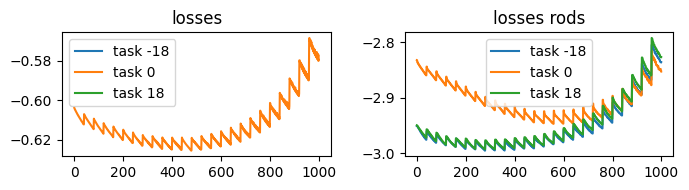

In [16]:
for i in range(1,41):
    train_a_while(0.5,20)
    check_structure(rho_next, offsets = task_offsets, fname=f'struct_0.5_{20*i}')
    check_loss(1000, fname=f'loss_0.5_{100*i}')
    EPS_MIN_ROD += 0.002
    EPS_MAX_ROD -= 0.002

In [17]:
saveall()
loadall()


(array([ 0.0000,  0.0000,  0.0000, ...,  0.0000,  0.0000,  0.0000]),
 {-18: array([ 0.5000,  0.5000,  0.5000, ...,  0.5000,  0.5000,  0.5000]),
  0: array([ 0.5000,  0.5000,  0.5000, ...,  0.5000,  0.5000,  0.5000]),
  18: array([ 0.5000,  0.5000,  0.5000, ...,  0.5000,  0.5000,  0.5000])},
 [array([-0.8656, -0.8491, -0.3070, ...,  0.5790,  0.5801,  0.5774])],
 {-18: array([-5.9987, -3.0726, -1.5369, ...,  2.8363,  2.8360,  2.8362]),
  0: array([-5.9757, -2.8057, -1.2302, ...,  2.8485,  2.8531,  2.8531]),
  18: array([-5.9987, -3.0776, -1.5477, ...,  2.8273,  2.8270,  2.8271])})

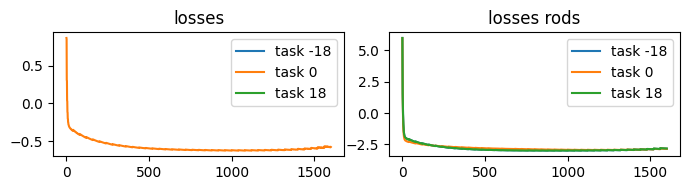

In [18]:
check_loss(100000, fname=f'allloss_0.5_{100*i}')

In [19]:
rho_next, rods_dict, losses, losses_rods = loadall()
EPS_MIN_ROD, EPS_MAX_ROD = 0.98,1.02

In [20]:
check_structure_for_paper(rho_next, offsets = task_offsets, fname=f'struct_final')

<ipython-input-7-d26a2201a1c0>:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return rho*design_region + bg_rho*(design_region==0).astype(np.float)
<ipython-input-9-97639221a84f>:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_source = np.zeros_like(source,dtype=np.float)
<ipython-input-9-97639221a84f>:14: DeprecationWarning: `